In [2]:
import numpy as np 
from gymnasium import Env, spaces
import matplotlib.pyplot as plt
from tqdm import tqdm

# Policy Gradient Methods

A major branch of reinforcement learning is that of policy gradient methods. The defining characteristic of 
these methods is that they learn a policy rather than construct it based on state-action values. For example, in our Q-learning algorithm we learned Q-values and converted these to probabilities using the $\epsilon$-greedy strategy. 

Policy gradients learn a policy by using.. gradients. But gradients of what? In general it is the gradient of a performance metric, e.g. expected return, $J$ wrt. the policy parameters $\mathbf{\theta}$. The expected return is quite generally given by 

$
\begin{equation}
J(\theta) = \sum_{s \in \mathcal{S}} d^\pi(s) V^\pi(s) = \sum_{s \in \mathcal{S}} d^\pi(s) \sum_{a \in \mathcal{A}} \pi_\theta(a|s)Q^\pi(s,a)
\end{equation}
$

Here $d^\pi$ is the distribution of states when following policy $\pi$, $V^\pi(s)$ and $Q^\pi(s, a)$ are the state-value and state-action value functions under policy $\pi$, note 
these are not approximate learned value-functions but the true ones. So if we can calculate $\nabla_\theta J(\theta)$ then we can improve the policy by moving in the direction of that 
gradient! 

A rather long derivation (see [Sutton & Barto](https://www.andrew.cmu.edu/course/10-703/textbook/BartoSutton.pdf) p. 325 for the full thing) leads to the so called policy gradient theorem
$
\begin{equation}
\nabla J(\mathbf{\theta}) \propto \sum_{s \in \mathcal{S}} d^\pi(s) \sum_a Q_\pi(s, a) \nabla \pi(a|s, \mathbf{\theta})
\end{equation}
$

This is an important result in that it shows that the gradient of $J$ depends only on the gradient of $\pi$ and not $Q(s,a)$ or $d(s)$. 

So in a policy-gradient method what we want to do is just gradient ascent on the parameters of our policy according to the gradient of expected return. 

$ \theta_{t+1} = \theta_t + \alpha \nabla J(\mathbf{\theta}) $

The difficulty with this expression is for $\nabla J(\theta)$ is the sum over all states and all actions, especially as we don't directly know $d_\pi(s)$ as it is
the distribution of states that results from following policy $\pi$, but not something we can directly calculate. 

### REINFORCE 

The **RE**ward **I**ncrement = **N**on-negative **F**actor $\times$ **O**ffset **R**einforcement $\times$ **C**haracteristic **E**ligibility (REINFORCE) is a feat in acronym construction only rivaled by its importance for policy gradient methods, as it serves as foundation for many other algorithms. 

The expression for the policy gradient in REINFORCE starts by noting that we really dont want to directly perform the sum $\sum_{s\in\mathcal{S}} d^\pi(s)$ directly, but 
when we follow the policy $\pi$ we get samples according to this probability, so 

$
\begin{equation}
\begin{aligned}
\nabla J(\mathbf{\theta}) & \propto \sum_{s \in \mathcal{S}} d^\pi(s) \sum_a Q_\pi(s, a) \nabla \pi(a|s, \mathbf{\theta}) \\
& = E_\pi \left[ \sum_a Q_\pi(s_t, a) \nabla \pi(a|s_t, \mathbf{\theta}) \right]
\end{aligned}
\end{equation}
$

where $s_t$ are samples of states visited while following policy $\pi$. The same strategy lets us replace the sum over all actions but 
we need to multiply by $\frac{\pi(s, a)}{\pi(s, a)}$ to do so, because expectation is a sum over probability times the random variable and we lack the probability term, so 

$
\begin{equation}
\begin{aligned}
\nabla J(\mathbf{\theta}) & \propto E_\pi \left[ \sum_a \pi(a|s_t, \mathbf{\theta}) Q_\pi(s_t, a) \frac{\nabla \pi(a|s_t, \mathbf{\theta})}{\pi(a|s_t, \mathbf{\theta})} \right] \\
& = E_\pi \left[Q_\pi(s_t, a_t) \frac{\nabla \pi(a|s_t, \mathbf{\theta})}{\pi(a|s_t, \mathbf{\theta})} \right]
\end{aligned}
\end{equation}
$

Now we can note that the state-action value function $Q(s, a)$ is defined as the expectation value under $\pi$ of the return $G_t$, so 

$
\begin{equation}
\begin{aligned}
\nabla J(\mathbf{\theta}) & \propto E_\pi \left[Q_\pi(s_t, a_t) \frac{\nabla \pi(a|s_t, \mathbf{\theta})}{\pi(a|s_t, \mathbf{\theta})} \right] \\
& = E_\pi \left[G_t \frac{\nabla \pi(a_t|s_t, \mathbf{\theta})}{\pi(a_t|s_t, \mathbf{\theta})} \right]
\end{aligned}
\end{equation}
$

We need not worry that we have only derived an expression proportional to the gradient, 
as any missing proportionality constants are simply swallowed by the learning rate $\alpha$.
An interpretation of this expression is
- The term $\nabla \pi(a|s_t, \mathbf{\theta})$ determines the direction in the weight space that increases 
the probability of $a$ the fastest.
- If $G_t$ is small the update to the policy will be small, this causes parameters to move in the 
direction that increases the probability of actions that yield a high return. 
- Without the division by $\pi(a|s_t, \mathbf{\theta})$ actions that are chosen often to be favoured, as they will more 
often be seen in sample trajectories, with the term actions with low probability are given more weight in gradient ascent steps. 

Now to actually evaluate this expectation value we would need to sample a large number of trajectories, that is 
we would let our policy navigate through the environemnt a large number of times. But it can in fact work 
to just sample a single trajectory and only calculate the gradient based on that and then sort of 
hide the need for the expectation in the iterative nature of gradient ascent. 
With all of that in mind we can state the update rule simply as: 

$ \theta_{t+1} = \theta_{t} + \alpha G_t \frac{\nabla \pi(s_t|s_t, \theta_t)}{\pi(s_t|s_t, \theta_t)} $

The algorithm is neatly summarized by this pseudo-code from Sutton & Barto 

![Reinforce](images/reinforce.png)

There are two differences between the pseudo-code and the update rule, these are
1. It includes the discount factor $\gamma$
2. It uses the identity $ \nabla \ln(x) = \frac{\nabla x}{x}$

The Monte-Carlo in the name comes from the need to learn on complete episodes, as a sample of the 
full return $G_t$ is needed. You can think of Monte-Carlo RL methods as traversing all the way down 
to a terminal state of the tree of the MDP before being able to update, see the figure at the bottom 
of [this section of LilLog](https://lilianweng.github.io/posts/2018-02-19-rl-overview/#combining-td-and-mc-learning) for a visualization. 

We will start our exploration of policy-gradient methods by implemeting REINFORCE. 

### Short Corridor environment. 

As a starting point for implementing policy gradient approach we will tackle an environment that is problematic for value-based approaches, such as the Q-learning we have played around with before. 
This environment consists of a short corridor, that we can represent visually as such: 

```
| S | r | n | G | 
```

Where `S` is the starting state, `G` is the goal state, `n` is a normal state and `r` is a reverse state where the directions of actions are swapped such that attempting to go right leads to going left and attempting to left leads to going right. Additionally we will blindfold our agent, so it will not be able to see which state it is currently in. 
Each step the agent takes yields a reward of $-1$, so a perfect sequence of [right, left, right] leads to a reward of $-3$. However, given the blindfold we can only expect the agent to learn the probability of going in each direction that leads to the on average shortest trip through the corridor. 

If we were to tackle this problem with a value based approach with an $\epsilon$-greedy strategy there are only two possbilities for the agent 

$ p(\mathrm{left}) = 1 - \frac{\epsilon}{2} \ \ \ $ & $ \ \ \ p(\mathrm{right}) = \frac{\epsilon}{2} $

$ p(\mathrm{left}) = \frac{\epsilon}{2} \ \ \ $ & $ \ \ \ p(\mathrm{right}) = 1 - \frac{\epsilon}{2} $

The agent cannot learn the optimal strategy, the optimal strategy is only obtainable with setting $\epsilon$ correctly and $\epsilon$ is a hyperparameter not a learnable parameter. 

The cell below implements this environment. 

In [2]:
class ShortCorridorEnv(Env):
    
    def __init__(self):        
        self.REVERSE_STATE = 1
        self.GOAL_STATE = 3
        self.NUM_STATES = self.GOAL_STATE + 1
        
        self.current_state = 0

        self.observation_space = spaces.Discrete(1)        
        self.action_space = spaces.Discrete(2) 

    def step(self, action):
        if action == 0: # Move left
            step = -1
        else: # Move right
            step = 1
        
        if self.current_state == self.REVERSE_STATE:
            step = - step
        
        # Advance
        self.current_state += step

        # Move agent back inside the corridor if it goes out on the left side.
        self.current_state = max(0, self.current_state)
        
        ob = 0 # Observation is always just 0. This is the blindfold. Agent cant tell the difference between each state.
        reward = -1 # Reward is always -1.
        done = self.current_state >= self.GOAL_STATE

        return ob, reward, done, False, {}

    def reset(self):
        self.current_state = 0
        return 0

To illustrate the problem with value-based approach lets plots the average return as a function of the probability of 
going to the right. 

(An expression for this can also be calculated analytically, but that requires doing more math and less 
code so no thanks.)

In [3]:
def value_at_probability(prob, restarts=1000):

    env = ShortCorridorEnv()

    returns = []
    for _ in range(restarts):

        rewards = []
        state = env.reset()
        terminal = False

        while not terminal:
            if np.random.rand() < prob:
                action = 1
            else:
                action = 0

            # action = np.random.choice([0, 1], p=[1-prob, prob])

            new_state, reward, terminal, _, _ = env.step(action)
            state = new_state
            rewards.append(reward)
        
        returns.append(np.sum(rewards))

    return np.array(returns)

probs = np.linspace(0.04, 0.96, 100)
average_returns = [value_at_probability(p).mean() for p in probs]


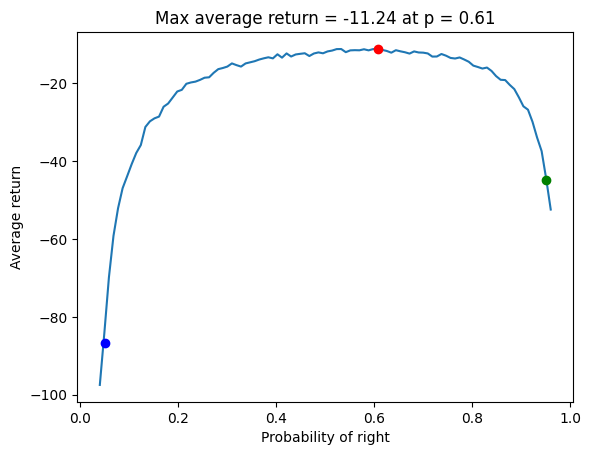

In [4]:
fig, ax = plt.subplots()

ax.plot(probs, average_returns)
i = np.argmax(average_returns)
ax.plot(probs[i], average_returns[i], 'ro', label='Optimal strategy')

epsilon = 0.1
pright = 1 - epsilon / 2
vright = value_at_probability(pright).mean()

pleft = epsilon / 2
vleft = value_at_probability(pleft).mean()

ax.plot(pright, vright, 'go', label='Right strategy')
ax.plot(pleft, vleft, 'bo', label='Left strategy')

ax.set_xlabel('Probability of right')
ax.set_ylabel('Average return')

ax.set_title('Max average return = {:.2f} at p = {:.2f}'.format(average_returns[i], probs[i]))

plt.show()

So we see that the optimal is about a probability of moving right of about 0.59 which yields a average return of about -11.6.
Either of the possible strategies with value-based $\epsilon$-greedy strategies yield much worse average returns and cannot 
be improved. 

That we can actually calculate the above curve proves that this is in fact very much a toy environment, but I find 
it very illustrative in order to implement REINFORCE. 

Now that we have an understanding of the environment lets implement the REINFORCE algorithm for this problem. 
To do so we need to decide on a per the pseudo-code 'differentiable policy parametertization', at which point you are probably foaming at the mouth at the possibility of a neural network, but we will start simpler than that. 

We will choose the following 'differentiable policy parametertization' instead: 

$
\pi(s, a_i) = \frac{\exp{\theta_i}}{\sum_j \exp{\theta_j}}
$

Here $\theta_i$ is the action preference for action $i$. We throw the learned action 
preferences through a softmax distribution, so the bigger $\theta_0$ is compared to $\theta_1$ the higher the probability of choosing action 0. 
We can just use the REINFORCE gradient ascent update rule

$ \theta_{t+1} = \theta_{t} + \alpha G_t \frac{\nabla \pi(A_t|S_t, \theta_t)}{\pi(A_t|S_t, \theta_t)} $

But it is very common in policy-gradient methods to express these in terms of the gradient of the log probability, as we saw in the pseudo-code, so we will
choose to do that instead. 

The log derivatives can be written for two cases, when the index of the derivative is the same as the action and when it is not. 
(There might be a cleaner way, so if you come up with that congratz.)

$
\frac{d}{d\theta_i} \ln \pi(s, a_i) = \frac{\sum_{j,j\neq i}\exp{\theta_i}}{\sum_j\exp\theta_j} 
$

$
\frac{d}{d\theta_k} \ln \pi(s, a_i) = -\frac{\exp{\theta_k}}{\sum_j\exp\theta_j} 
$

So for $ i = 0$ with our parameterization with two weights we have 

$
\frac{d}{d\theta_0} \ln \pi(s, a_0) = \frac{\exp{\theta_1}}{\exp\theta_0 + \exp\theta_1} 
$

$
\frac{d}{d\theta_1} \ln \pi(s, a_0) = -\frac{\exp{\theta_1}}{\exp\theta_0 + \exp\theta_1} 
$

And similar expressions for $\frac{d}{d\theta_0} \ln \pi(s, a_1)$ and $\frac{d}{d\theta_1} \ln \pi(s, a_1)$

Lets implememt this policy parameterization below

In [5]:
class Policy:

    def __init__(self):
        # The policy is parameterized by theta.
        # Dont change these values, you will risk.. making the problem too easy.
        self.theta=np.array([np.log(1), np.log(19)])

    def probability(self, state, action):
        """
        Calculate the probability of taking action a in state s.

        The reason the state is not used here is the aforementioend blind fold.
        If you are still unhappy with this then imagine that we represent 
        each state-action pair with a feature vector as such: 
        - Action 0 for all states: [1, 0]
        - Action 1 for all states: [0, 1]
        Then we can calculate the action preference for each state-action pair
        with a dot product between theta and the state-action pair feature. 
        """
        prefs = self.theta - np.max(self.theta) # This fixes overflows. 
        exps = np.exp(prefs) 
        p = exps[action] / np.sum(exps)
        return p
    
    def __call__(self, state):
        """
        Sample an action from the policy by using the probabilities. 
        """
        p = self.probability(state, 0)
        r = np.random.rand()
        if r < p:
            return 0
        else:
            return 1

    def log_gradient(self, state, action):
        """
        Calculate the gradient of the log of the policy with respect to theta
        Return a np.array with two elements. 
        """
        exps = np.exp(self.theta)
        sum_exps = np.sum(exps)

        if action == 0: 
            c1 = exps[1] / sum_exps
            c2 = -exps[1] / sum_exps
        elif action == 1:
            c1 = -exps[0] / sum_exps
            c2 = exps[0] / sum_exps
        return np.array([c1, c2])        

Now we are ready to implement the REINFORCE training loop, which again in pseudo-code is

![Reinforce](images/reinforce.png)

In a few more words this means: 

1. Run an episode following the policy and collect all the states, actions and rewards.
2. For each step of the collected trajectory calculate the return from the current state $G$ and perform a gradient step using the log gradient we implemented. 

So for each episode we will perform as many gradient ascent steps as there were actions, and then we will never use that data again. 

For this environemnt we will use $\gamma = 1$ so you can ignore the inclusion of the discount factor. 

<div class="alert alert-block alert-info">
<b>Tip:</b> The pseudo-code says that the sum should go to T-1 but note that this corresponds to all state-action pairs except because of how the indexing is done. 

</div>


In [6]:
def train_policy(alpha=2**(-13), episodes=500):
    # Environment, policy and value: 
    env = ShortCorridorEnv()
    policy = Policy()

    # Storage of returns:
    returns = np.zeros(episodes)

    for episode in range(episodes):

        # Reset the environment:    
        state = env.reset()
        terminal = False

        # Collection of episode statistics:
        trajectory = []

        # Run the episode:
        G = 0 
        while not terminal and len(trajectory) < 1000:
            action = policy(state)
            new_state, reward, terminal, _, _ = env.step(action)
            G += reward

            trajectory.append((state, action, reward))
            state = new_state

        # Store the return
        returns[episode] = G

        # Perform the update step: 
        T = len(trajectory) 
        Gt = G
        for t in range(T):
            # Get the state, action and reward:
            state, action, reward = trajectory[t]
            
            # Update the policy:
            gradient = policy.log_gradient(state, action)
            policy.theta += alpha * G * gradient

            # Update the return for the next iteration by substracting the reward. 
            Gt -= reward

    return returns

There is a rather high amount of variance in the result of this training, so we will do many restarts and observe the average return as a function of training steps.  

In [13]:
restarts = 100

returns = []
for restart in tqdm(range(restarts)):
    returns.append(train_policy(alpha=2**(-13)))

returns = np.array(returns)                                   

  0%|                                                                                                          | 0/100 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.88it/s]


Text(0, 0.5, 'Average Return')

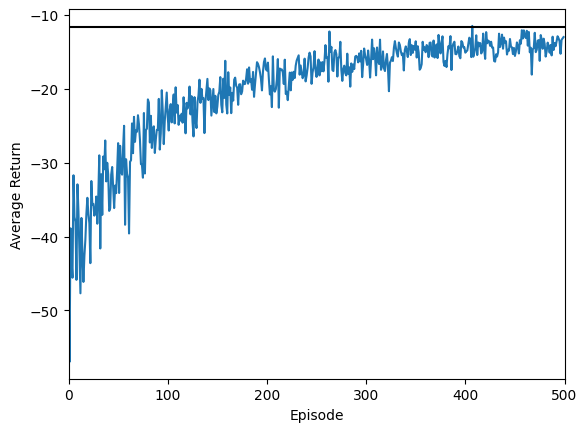

In [14]:
fig, ax = plt.subplots()
ax.plot(returns.mean(axis=0))
ax.axhline(-11.6, color='k')
ax.set_xlim([0, 500])

ax.set_xlabel('Episode')
ax.set_ylabel('Average Return')

REINFORCE is really the basis of most or all policy gradient methods, newer algorithms focus on making the training more stable or the algorithm more data efficient (e.g. by using replay). 

Perhaps the simplest improvement is that of using a baseline to reduce variance of the policy gradient, this is done by subtracting something a baseline $b(s)$ that may depend on the state, but not on the action. 

$\nabla J(\mathbf{\theta}) \propto \sum_s \mu(s) \sum_a [Q_\pi(s, a)-b(s)] \nabla \pi(a|s, \mathbf{\theta})$

Going through the whole policy gradient theorem derivation with this starting point (again, see Sutton & Barto for details), leads to 
an expression for REINFORCE with a baseline

$ \theta_{t+1} = \theta_{t} + \left( \alpha G_t - b(S_t) \right) \frac{\nabla \pi(A_t|S_t, \theta_t)}{\pi(A_t|S_t, \theta_t)} $

Which if $b(S_t) = 0$ for all $S_t$ is equal to the previous expression. Now it may not be too intuitive why this would matter, so lets first 
try to investigate that. 

In [6]:
# Imagine we have a policy that is a function of one parameter, 
# We have three samples from this policy consiting of the log gradient and the return. 
log_grad = np.array([0.2, 0.3, 0.5]) # These numbers essentially describe how fast the probability of the action increases with the parameter
returns = np.array([10, 11, 12]) 

# Without baseline:
mean = np.sum(log_grad * returns) / len(returns)
var = np.sum((log_grad * returns - mean)**2) / (len(returns)-1)
print('Variance without baseline:', var)

# With baseline: 
baseline = 11
mean = np.sum(log_grad * (returns - baseline)) / len(returns)
var = np.sum((log_grad * (returns - baseline) - mean)**2) / (len(returns)-1)
print('Variance with baseline:', var)

Variance without baseline: 4.163333333333333
Variance with baseline: 0.13


As we can see, this dramatically reduces the variance of the gradient, as long as we have chosen an appropriate baseline.

So how do we do that for the our REINFORCE algorithm? Well one option is the value of the state, which can be learned alongside the policy! 
That is the basic idea of REINFORCE with a baseline. The pseudo-code looks like so: 

![reinforce_baseline](images/reinforce_baseline.png)

As we are still working with a very simple example, we will choose a very simple value function parameterization, namely just a single learnable weight $w$. 

Again we will ignore discount factor.

In [10]:
class ValueFunction:

    def __init__(self):
        # Again dont change this value.
        self.w = np.array([0.])

    def __call__(self, s):
        return self.w

    def gradient(self, s):
        return 1

def train_policy_baseline(alpha=2**(-13), alpha_w=2**(-6), episodes=500):
    # Environment, policy and value: 
    env = ShortCorridorEnv()
    policy = Policy()
    value = ValueFunction()

    # Storage of returns:
    returns = np.zeros(episodes)

    for episode in range(episodes):

        # Reset the environment:    
        state = env.reset()
        terminal = False

        # Collection of episode statistics:
        trajectory = []

        # Run the episode:
        G = 0 
        while not terminal and len(trajectory) < 1000:
            action = policy(state)
            new_state, reward, terminal, _, _ = env.step(action)
            G += reward

            trajectory.append((state, action, reward))
            state = new_state

        # Store the return
        returns[episode] = G

        # Perform the update step: 
        T = len(trajectory)
        Gt = G
        for t in range(T):

            # Get the state, action and reward:
            state, action, reward = trajectory[t]

            # Calculate G and delta
            delta = Gt - value(state)

            # Update the value function:
            value.w += alpha_w * delta #* value.gradient(states[t])
            
            # Update the policy:
            gradient = policy.log_gradient(state, action)
            policy.theta += alpha * delta * gradient

            # Update the return for the next iteration by substracting the reward. 
            Gt -= reward

    return returns

In [11]:
restarts = 100 # 100 takes about 2 minutes for my code. 

returns_std = []
for restart in tqdm(range(restarts)):
    returns_std.append(train_policy_baseline(alpha=2**(-13), alpha_w=0)) # Using learning rate of 0 and initial w of 0 is equivalent to not using a baseline. 
returns_std = np.array(returns_std)

# I have carefully copied the hyperparameters from Sutton & Barto, but you can 
# check yourself that the above line does not work with alpha=2**(-9)! 
# This higher learning rate only works with the baseline! 
returns_baseline = []
for restart in tqdm(range(restarts)):
    returns_baseline.append(train_policy_baseline(alpha=2**(-9), alpha_w=2**(-6)))
    
returns_baseline = np.array(returns_baseline)

  1%|▉                                                                                                 | 1/100 [00:00<00:42,  2.33it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.60it/s]


Text(0, 0.5, 'Average Return')

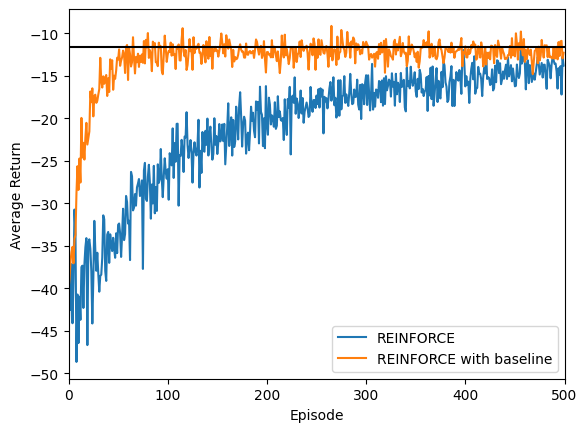

In [12]:
fig, ax = plt.subplots()
ax.plot(returns_std.mean(axis=0), label='REINFORCE')
ax.plot(returns_baseline.mean(axis=0), label='REINFORCE with baseline')
ax.axhline(-11.6, color='k')
ax.set_xlim([0, 500])
ax.legend()

ax.set_xlabel('Episode')
ax.set_ylabel('Average Return')

So, we can quite clearly conclude that the usage of a baseline does indeed significantly improve the agents ability to learn 
this problem, as it reduces the variance of the policy update and allows for a higher learning rate. 
For on-policy algorithms we want to push the learning rate as a high as possible as we only used 
the data from each episode once, if the learning rate we are paying a high computational price for the data 
for very little 'movement' in the weight landscape and thus slow convergeence towards an optimal policy. 
On the other hand if the learning rate is too high, then the agent will not learn as the policy constantly 
forgets working strategies. So we need the right learning rate for the quality of our gradient and a higher 
quality gradient, as can be achieved with baseline, allows for a higher learning rate. 

This concludes this notebook, in the next one we will implement REINFORCE using neural networks. 